# Cross-matching entre catalogues X et optique

"Entraînement" au cross-matching avec les catalogues erosita et sdss_wen → envoyé par Reza dans un mail du 14/02/2025 à 12h26

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math as m 
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table


In [65]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

# Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [66]:
#Description des tables :
# catass -  est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen 
# dtass - contient juste l'information d'association, pour l'objet la plus proche (en angle) 
# dtassall - contient l'information d'association , uniquement pour les objets X ayant été associés à un objet optique, et tous les objets qui passent le critère d'association (angulaire et en redshift) 

'''
#Ne fonctionnait car le cgicher étaut un fits binary
def fits_to_dataframe_catass(fits_file):
    with fits.open(fits_file) as hdul:
        catass = hdul[1].data 
        catass_df = pd.DataFrame(catass)

        dtass_binary = hdul[2].data 
        dtass = Table(dtass_binary) 
        dtass.write('dtass.fits', overwrite=True, format='ascii') 
        dtass_df = pd.DataFrame(dtass)

        dtassall = hdul[3].data 
        dtassall_df = pd.DataFrame(dtassall)
    return catass_df, dtass_df, dtassall_df'''

# Transforme certaines extensions d'un fichier FITS en un fichier FITS ASCII
def fits_binary_to_fits_ascii_list(fits_file, liste_indexes, name_list):  # liste_indexes indique les extensions du fits à lire ; name_list correspond aux noms des fichiers de sortie
    for x, x_name in zip(liste_indexes, name_list):  # Use zip to iterate over both lists simultaneously
        with fits.open(fits_file) as hdul:
            data = hdul[x].data
            data_table = Table(data)  # Convertit le tableau binaire en un tableau astropy
            data_table.write(x_name, overwrite=True, format='ascii')  # Écrit le tableau dans un fichier FITS ASCII

# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df

def ascii_to_dataframe(ascii_file, delimiter=' '):
    data_df = pd.read_csv(ascii_file, delimiter=delimiter)
    return data_df

# Transforme certaines extensions d'un fichier FITS en un DataFrame pandas(→ pour que ça fonctionne, il faut un fits ascii et pas un fits binaire)
def fits_to_dataframe_list(fits_file, liste_indexes):  # liste_indexes indique les extensions du fits à lire
    df_list = []  # Initialize the list outside the loop
    with fits.open(fits_file) as hdul:
        for x in liste_indexes:
            data = hdul[x].data  # Select the data in the xth extension
            df_list.append(pd.DataFrame(data))
            print(df_list)
    return df_list  # Return the entire list of DataFrames

#def fits_binary_to_fits_ascii(fits_file):

On précise le chemin menant à chacun des catalogues

In [67]:
path_X = 'clxB.fits' #la première table est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen
name_X = 'eROSITA_BULBUL_2024'

path_opt = '../SDSS_ROSAT/Wen_2012_SDSS_ascii.fit'
name_opt = 'Wen_2012_SDSS'

On les convertit en dataframe et on affiche leur structure :

In [68]:
clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!

fits_binary_to_fits_ascii_list('clxB.fits',[2,3],['clx_dtass.ascii','clx_dtassall.ascii']) 

In [69]:
clx_dtass_df = ascii_to_dataframe('clx_dtass.ascii') 
clx_dtassall_df = ascii_to_dataframe('clx_dtassall.ascii')

In [70]:
# On veut récupérer la table Erosita de départ que Reza a utilisé → Ezra Bulbul 2024
columns_to_exclude = ['idm', 'asscnt','idass','dstass','delz','maxassdist','zph','rmag','r200','N200']
table_X = clx_catass_df.drop(columns=columns_to_exclude) # Pour l'instant, table eRosita


In [71]:
table_X

,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,pcont,...,CTS300kpc,CTS500,F500,L500,KT,Mgas500,YX500,M500,Fgas500,R500
0,0.021730,-38.624903,1eRASS J000005.2-383729 ...,0.021730,-38.624903,94.800003,0.3153,0.0079,photo_z,0.006,...,33.4,48.2,47.110,140.172,1.90,279.160004,553.19,36.070000,0.075,971
1,0.089191,-82.831715,1eRASS J000021.4-824954 ...,0.089191,-82.831715,184.199997,0.0891,0.0002,cg_spec_z,0.000,...,128.8,189.5,98.355,24.747,NaN,111.919998,0.00,16.990000,0.065,819
2,0.129422,-50.151013,1eRASS J000031.0-500903 ...,0.129422,-50.151013,117.300003,0.0681,0.0002,cg_spec_z,0.218,...,29.9,30.3,23.991,2.862,1.79,1.920000,9.34,3.630000,0.009,493
3,0.132712,-63.025286,1eRASS J000031.8-630131 ...,0.132712,-63.025286,139.600006,0.2448,0.0058,photo_z,0.005,...,24.3,49.6,33.228,57.877,NaN,171.949997,0.00,22.040001,0.076,846
4,0.189080,-46.394874,1eRASS J000045.3-462341 ...,0.189080,-46.394874,109.500000,0.0925,0.0004,cg_spec_z,0.715,...,20.0,20.8,16.818,3.996,0.96,6.400000,11.17,3.780000,0.019,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12242,359.741833,-60.612333,1eRASS J235858.0-603644 ...,359.741833,-60.612333,142.500000,0.1052,0.0064,photo_z,0.000,...,204.7,506.8,337.065,97.721,NaN,358.950012,0.00,38.669998,0.093,1071
12243,359.799123,-55.296727,1eRASS J235911.7-551748 ...,359.799123,-55.296727,130.800003,0.2137,0.0063,photo_z,0.506,...,15.3,15.8,11.402,15.028,NaN,5.590000,0.00,8.150000,0.008,614
12244,359.864701,-34.306012,1eRASS J235927.5-341821 ...,359.864701,-34.306012,87.500000,0.1138,0.0004,spec_z_boot,0.003,...,42.6,62.5,62.778,22.350,NaN,81.230003,0.00,14.110000,0.054,763
12245,359.980381,-44.205215,1eRASS J235955.2-441218 ...,359.980381,-44.205215,98.099998,0.5797,0.0117,photo_z,0.982,...,12.3,13.4,12.342,165.113,NaN,41.310001,0.00,25.920000,0.020,785


In [72]:
table_optique = fits_to_dataframe('../SDSS_ROSAT/Wen_2012_SDSS_ascii.fit')

In [73]:
table_optique

,_Glon,_Glat,_RAJ2000,_DEJ2000,WHL,RAJ2000,DEJ2000,zph,zsp,rmag,r200,RL_,N200,Other
0,110.449770,-29.412918,0.00236,32.20925,J000000.6+321233,0.00236,32.20925,0.1274,0.0000,14.92,1.72,70.63,24,Abell \r
1,100.049559,-55.283431,0.00957,5.28827,J000002.3+051718,0.00957,5.28827,0.1696,0.0000,16.20,0.94,17.48,9,\r
2,110.203228,-30.366812,0.01377,31.23175,J000003.3+311354,0.01377,31.23175,0.5428,0.0000,20.17,0.87,14.27,8,\r
3,110.350581,-29.827793,0.01475,31.78564,J000003.5+314708,0.01475,31.78564,0.0932,0.0000,15.18,0.94,16.97,9,\r
4,98.226082,-57.913027,0.01945,2.47386,J000004.7+022826,0.01945,2.47386,0.4179,0.0000,19.32,0.95,13.71,10,\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132679,107.667888,-38.665737,359.98712,22.67506,J235956.9+224030,359.98712,22.67506,0.3590,0.0000,18.27,1.00,19.46,11,\r
132680,104.152271,-47.689671,359.99329,13.29671,J235958.4+131748,359.99329,13.29671,0.1710,0.0000,16.57,0.91,14.23,11,\r
132681,96.879786,-59.541787,359.99500,0.70175,J235958.8+004206,359.99500,0.70175,0.0741,0.0817,14.89,1.01,19.64,11,AMF \r
132682,107.386151,-39.528437,359.99677,21.78513,J235959.2+214706,359.99677,21.78513,0.4303,0.0000,18.90,1.00,19.17,11,\r


# Tests fonctions gem_asmatch.py

Fonctions écrites et fournies par Reza dans le fichier gem_asmatch.py

In [74]:
list_coord_1 = [(1.0,1.0), (2.0,2.0), (3.0,3.0), (4.0,4.0), (5.0,5.0),(6.0,6.0), (7.0,7.0), (8.0,8.0), (9.0,9.0), (10.0,10.0)]
list_coord_2 = [(1.0,1.0), (3.0,3.0),(5.0,5.0),(7.0,7.0),(9.0,9.0)]

eps_ang = 0.1
results_1 = match_celestial_objects_list_deg(list_coord_1,list_coord_2,eps_ang)
print("results_1 : ", results_1)

results_1 :  [(np.int64(0), np.int64(0)), (np.int64(2), np.int64(1)), (np.int64(4), np.int64(2)), (np.int64(6), np.int64(3)), (np.int64(8), np.int64(4))]


In [75]:
"""test_skycoord = create_skycoord_from_fits(clx_catass_df)
print(test_skycoord)"""

'test_skycoord = create_skycoord_from_fits(clx_catass_df)\nprint(test_skycoord)'

# Applications sur les tables

## Association X → optique

In [76]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_coords_X = []
for i in range(len(table_X)):
    coord = (table_X['RAJ2000'][i],table_X['DEJ2000'][i])
    liste_coords_X.append(coord)

liste_coords_optique = []
for i in range(len(table_optique)):
    coord = (table_optique['RAJ2000'][i],table_optique['DEJ2000'][i])
    liste_coords_optique.append(coord)


In [77]:
tolerance_ang = 600 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)
delta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)
indices_crossed_list = match_celestial_objects_list_deg(liste_coords_X,liste_coords_optique,tolerance_ang) # [indice_X, indice_optique]
# ↑ La différence de z n'est pas pris en compte ici, on va prendre en compte ce seuil après


In [78]:
#On identifie les objets X qui ont été associés à strictement plus de 1 objet optique
data = indices_crossed_list



# Ici, on récupère les indices pour chaque association, un indice X est donc répété autant de fois que ce cluster est associé à un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_X_crossed_repetitifs")
indices_X_crossed_repetitifs = []
indices_opt_repetitifs = []
for x in data :
    indices_X_crossed_repetitifs.append(x[0])
    indices_opt_repetitifs.append(x[1])

# Ici, on ne garde qu'une seule occurrence de chaque cluster X associé à au moins un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_X_crossed")
indices_X_crossed = set()
for float1, float2 in data:
    if float1 in indices_X_crossed:
        print(f"Duplicate found: {float1}")
    else:
        indices_X_crossed.add(float1)
indices_X_crossed = sorted(indices_X_crossed)



Duplicate found: 619
Duplicate found: 621
Duplicate found: 621
Duplicate found: 678
Duplicate found: 678
Duplicate found: 682
Duplicate found: 682
Duplicate found: 682
Duplicate found: 721
Duplicate found: 757
Duplicate found: 815
Duplicate found: 838
Duplicate found: 903
Duplicate found: 903
Duplicate found: 927
Duplicate found: 927
Duplicate found: 927
Duplicate found: 969
Duplicate found: 969
Duplicate found: 969
Duplicate found: 1098
Duplicate found: 1098
Duplicate found: 1158
Duplicate found: 1158
Duplicate found: 1240
Duplicate found: 1240
Duplicate found: 1450
Duplicate found: 1451
Duplicate found: 1451
Duplicate found: 1451
Duplicate found: 1470
Duplicate found: 1491
Duplicate found: 1504
Duplicate found: 1504
Duplicate found: 1505
Duplicate found: 1511
Duplicate found: 1511
Duplicate found: 1559
Duplicate found: 1570
Duplicate found: 1587
Duplicate found: 1587
Duplicate found: 1587
Duplicate found: 1587
Duplicate found: 1639
Duplicate found: 1639
Duplicate found: 1639
Duplicat

### table_X_crossed_repetitifs 

Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il y aura 3 fois l'indices du cluster A dans la table "table_X_crossed_repetitifs".

In [79]:
# Il peut y avoir plusieurs occurences d'un même objet X dans cette liste
table_X_crossed_repetitifs = table_X.iloc[indices_X_crossed_repetitifs]
table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_X_crossed_repetitifs = table_X_crossed_repetitifs[['__indexes'] + [col for col in table_X_crossed_repetitifs.columns if col != '__indexes']]

C:\Users\ED282972\AppData\Local\Temp\ipykernel_3428\1858826165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs


In [80]:
table_X_crossed_repetitifs

,__indexes,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,...,CTS300kpc,CTS500,F500,L500,KT,Mgas500,YX500,M500,Fgas500,R500
598,598,23.495303,-20.331114,1eRASS J013358.8-201952 ...,23.495303,-20.331114,143.600006,0.6019,0.0073,photo_z,...,10.4,16.6,10.814,151.417,NaN,240.720001,0.00,21.00,0.102,725
619,619,23.918737,-20.166027,1eRASS J013540.4-200957 ...,23.918737,-20.166027,144.100006,0.3080,0.0093,photo_z,...,24.1,27.5,16.654,55.143,NaN,84.660004,0.00,16.98,0.048,758
619,619,23.918737,-20.166027,1eRASS J013540.4-200957 ...,23.918737,-20.166027,144.100006,0.3080,0.0093,photo_z,...,24.1,27.5,16.654,55.143,NaN,84.660004,0.00,16.98,0.048,758
621,621,23.982636,-20.748073,1eRASS J013555.8-204453 ...,23.982636,-20.748073,144.699997,0.3800,0.0080,photo_z,...,48.6,72.5,46.054,231.008,NaN,405.170013,0.00,49.66,0.083,1054
621,621,23.982636,-20.748073,1eRASS J013555.8-204453 ...,23.982636,-20.748073,144.699997,0.3800,0.0080,photo_z,...,48.6,72.5,46.054,231.008,NaN,405.170013,0.00,49.66,0.083,1054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,11123,232.614267,-12.950820,1eRASS J153027.4-125702 ...,232.614267,-12.950820,222.800003,0.5063,0.0090,photo_z,...,36.3,39.7,16.651,198.249,NaN,86.040001,0.00,31.76,0.030,865
11144,11144,234.487709,-15.987236,1eRASS J153757.0-155914 ...,234.487709,-15.987236,105.699997,0.4475,0.0092,photo_z,...,16.2,26.6,23.573,190.021,NaN,335.970001,0.00,32.57,0.102,892
11145,11145,234.591375,-20.423985,1eRASS J153821.9-202526 ...,234.591375,-20.423985,106.199997,0.1875,0.0053,photo_z,...,7.6,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2147483648
11148,11148,235.507387,-14.094910,1eRASS J154201.7-140541 ...,235.507387,-14.094910,105.000000,0.2376,0.0058,photo_z,...,25.6,60.7,50.555,120.602,1.28,330.339996,440.69,35.43,0.091,993


In [87]:
table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == 619].iloc[0]['zBest']

np.float32(0.308)

In [91]:
X_row_of_interest = table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == 621].iloc[0]
X_row_of_interest['zBest']

np.float32(0.38)

In [82]:
table_X_crossed_repetitifs['zBest'][619]

619    0.308
619    0.308
Name: zBest, dtype: float32

In [83]:
X_row_of_interest = table_X_crossed_repetitifs.iterrows[619]

TypeError: 'method' object is not subscriptable

In [ ]:
table_X_crossed_repetitifs.iloc[619]

_RAJ2000                                              121.8938
_DEJ2000                                             14.207515
Name         1eRASS J080734.5+141227                       ...
RAJ2000                                               121.8938
DEJ2000                                              14.207515
Exp                                                  77.199997
zBest                                                   0.1867
e_zBest                                                 0.0013
zType                                         spec_z_boot     
pcont                                                    0.005
CR300kpc                                                 0.193
CR500                                                    0.416
CTS300kpc                                                 14.9
CTS500                                                    32.1
F500                                                      37.8
L500                                                   

In [93]:
diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_X_crossed_repetitifs)):
    index_X = indices_X_crossed_repetitifs[i] ; index_opt = indices_opt_repetitifs[i]

    X_row_of_interest = table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == index_X].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(X_row_of_interest['zBest'] - table_optique['zph'][index_opt]) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((X_row_of_interest['RAJ2000'] - table_optique['RAJ2000'][index_opt])**2 + (X_row_of_interest['DEJ2000'] - table_optique['DEJ2000'][index_opt])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_X_crossed_repetitifs['id_asso'] = indices_opt_repetitifs
table_X_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_X_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

In [96]:
table_X_crossed_repetitifs

,__indexes,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,...,L500,KT,Mgas500,YX500,M500,Fgas500,R500,id_asso,diff_z,dist_ang
598,598,23.495303,-20.331114,1eRASS J013358.8-201952 ...,23.495303,-20.331114,143.600006,0.6019,0.0073,photo_z,...,151.417,NaN,240.720001,0.00,21.00,0.102,725,12230,0.1856,0.146624
619,619,23.918737,-20.166027,1eRASS J013540.4-200957 ...,23.918737,-20.166027,144.100006,0.3080,0.0093,photo_z,...,55.143,NaN,84.660004,0.00,16.98,0.048,758,12503,0.0650,0.080360
619,619,23.918737,-20.166027,1eRASS J013540.4-200957 ...,23.918737,-20.166027,144.100006,0.3080,0.0093,photo_z,...,55.143,NaN,84.660004,0.00,16.98,0.048,758,12539,0.0097,0.155678
621,621,23.982636,-20.748073,1eRASS J013555.8-204453 ...,23.982636,-20.748073,144.699997,0.3800,0.0080,photo_z,...,231.008,NaN,405.170013,0.00,49.66,0.083,1054,12453,0.1113,0.092802
621,621,23.982636,-20.748073,1eRASS J013555.8-204453 ...,23.982636,-20.748073,144.699997,0.3800,0.0080,photo_z,...,231.008,NaN,405.170013,0.00,49.66,0.083,1054,12496,0.0152,0.009994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,11123,232.614267,-12.950820,1eRASS J153027.4-125702 ...,232.614267,-12.950820,222.800003,0.5063,0.0090,photo_z,...,198.249,NaN,86.040001,0.00,31.76,0.030,865,98290,0.0214,0.017526
11144,11144,234.487709,-15.987236,1eRASS J153757.0-155914 ...,234.487709,-15.987236,105.699997,0.4475,0.0092,photo_z,...,190.021,NaN,335.970001,0.00,32.57,0.102,892,99387,0.0007,0.003838
11145,11145,234.591375,-20.423985,1eRASS J153821.9-202526 ...,234.591375,-20.423985,106.199997,0.1875,0.0053,photo_z,...,NaN,NaN,NaN,NaN,NaN,NaN,-2147483648,99444,0.0139,0.008715
11148,11148,235.507387,-14.094910,1eRASS J154201.7-140541 ...,235.507387,-14.094910,105.000000,0.2376,0.0058,photo_z,...,120.602,1.28,330.339996,440.69,35.43,0.091,993,99904,0.0002,0.054777


Tout l'intéret de récupérer ce dataframe "table_X_crossed_repetitifs" est de pouvoir lui appliquer un seuil pour "diff_z" : en effet, l'association faite avec la fonction 'match_celestial_objects_list_deg' ne se basait que sur la distance angulaire entre les clusters.

In [104]:
# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift

table_X_crossed_3D = table_X_crossed_repetitifs[table_X_crossed_repetitifs['diff_z'] < delta_z]
print(np.round(100-(len(table_X_crossed_3D)/len(table_X_crossed_repetitifs))*100,1), " % des associations sont éliminées par le critère de redshift") 

30.8  % des associations sont éliminées par le critère de redshift


### table_X_crossed

Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice du cluster A dans la table "table_X_crossed".

In [ ]:
#Pour chaque objet X, on va identifier le nombre d'objets optiques associés, aisni que les indices de ces objets optiques

associations_dict_X = {}
for x in indices_X_crossed:
    associations_dict_X[x] = []
    for float1, float2 in indices_crossed_list:
        if float1 == x:
            associations_dict_X[x].append(float2)

#Maintenant, on va ajouter à chaque objet X le nombre d'objets optiques associés
for x in indices_X_crossed:
    num_associations = len(associations_dict_X[x])
    associations_dict_X[x] = (associations_dict_X[x], num_associations)

#On obtient un dictionnaire de la forme {indice_X : (indices_objets_optique, nombre_objets_optique_associés)}
print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) : ",'\n' )
associations_dict_X
            

Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) :  



{np.int64(598): ([np.int64(12230)], 1),
 np.int64(619): ([np.int64(12503), np.int64(12539)], 2),
 np.int64(621): ([np.int64(12453), np.int64(12496), np.int64(12548)], 3),
 np.int64(636): ([np.int64(12690)], 1),
 np.int64(664): ([np.int64(13029)], 1),
 np.int64(678): ([np.int64(13193), np.int64(13253), np.int64(13269)], 3),
 np.int64(682): ([np.int64(13193),
   np.int64(13253),
   np.int64(13269),
   np.int64(13325)],
  4),
 np.int64(721): ([np.int64(13627), np.int64(13686)], 2),
 np.int64(724): ([np.int64(13686)], 1),
 np.int64(757): ([np.int64(14243), np.int64(14269)], 2),
 np.int64(791): ([np.int64(14648)], 1),
 np.int64(815): ([np.int64(14860), np.int64(14918)], 2),
 np.int64(838): ([np.int64(15215), np.int64(15227)], 2),
 np.int64(903): ([np.int64(15782), np.int64(15845), np.int64(15881)], 3),
 np.int64(927): ([np.int64(15972),
   np.int64(15992),
   np.int64(16035),
   np.int64(16039)],
  4),
 np.int64(969): ([np.int64(16348),
   np.int64(16363),
   np.int64(16368),
   np.int64(16

In [ ]:
# On compare le nombres d'associations que j'obtiens avec celles dans clx_catass_df

# Moi
print(f"Nombres d'éléments associés dans les catalogues, avec une tolérance de {tolerance_ang} arcsecondes :",len(indices_crossed_list))
print('\n')

# clx_catass_df (Reza)
clx_catass_df_crossed = clx_catass_df[clx_catass_df['asscnt'] != 0]
print("A titre de comparaison, voici le nombre de clusters X qui ont au moins un cross-match en optique (dans le code par Reza)  :",len(clx_catass_df_crossed))

Nombres d'éléments associés dans les catalogues, avec une tolérance de 600 arcsecondes : 4127


A titre de comparaison, voici le nombre de clusters X qui ont au moins un cross-match en optique (dans le code par Reza)  : 1727


Maintenant, on récupère dans la table X les objets qui ont une association :

In [ ]:
table_X_crossed = table_X.iloc[indices_X_crossed] #; table_X_crossed = table_X_crossed.reset_index(drop=True) # On reset l'index pour ne pas avoir de mismacth dans les calculs par la suite
#table_optique_crossed = table_optique.iloc[indices_optique_crossed] ; table_optique_crossed = table_optique_crossed.reset_index(drop=True)

In [ ]:
#On calcule les informations d'associations "diff_z" et "dist_ang" pour chaque objet X

diff_z_list = [] # Liste qui va contenir les différences de redshift entre l'objet X et l'ensemble des objets optiques associés
dist_ang_list = [] # Liste qui va contenir les distances angulaires entre l'objet X et l'ensemble des objets optiques associés
for index, x in table_X_crossed.iterrows():
    obj_opt_ass = associations_dict_X[index][0] #liste des objets optiques associés à l'objet X courant
    diff_z = []
    dist_ang = []
    for j in range(len(obj_opt_ass)): # On parcourt la liste des objets optiques associés à l'objet X
        diff_z.append(abs(table_X_crossed['zBest'][index] - table_optique['zph'][obj_opt_ass[j]]))
        dist_ang.append(np.sqrt((table_X_crossed['RAJ2000'][index] - table_optique['RAJ2000'][obj_opt_ass[j]])**2 + (table_X_crossed['DEJ2000'][index] - table_optique['DEJ2000'][obj_opt_ass[j]])**2)) 
    diff_z_list.append(diff_z) # On ajoute la liste des différences de redshift à la liste diff_z_list
    dist_ang_list.append(dist_ang)
    #print(f"Index: {index}, Element: {x}")
    #print(associations_dict_X[i])
    # print(associations_dict_X[index])
    #print(associations_dict_X[index][0][j])
    """diff_z.append(abs(table_X_crossed['zBest'][i] - table_optique['Z'][associations_dict_X[i][0]]))
    diff_z_list.append(diff_z)"""

In [ ]:
# On ajoute les informations d'associations à table_X_crossed. En comparaison de ce qu'a fait Reza on a : Nb_assos <-> idm ; id_assos <-> idass ; diff_z <-> delz ; dist_ang <-> dstass  

#Nb_assos :
nb_assos_list = [x[1][1] for x in associations_dict_X.items()]
table_X_crossed['nb_assos'] = nb_assos_list

#id_assos :
id_assos_list = [x[1][0] for x in associations_dict_X.items()]
table_X_crossed['id_assos'] = id_assos_list

#diff_z
table_X_crossed['diff_z'] = diff_z_list

#dist_ang
table_X_crossed['dist_ang'] = dist_ang_list


C:\Users\ED282972\AppData\Local\Temp\ipykernel_22696\1990546439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed['nb_assos'] = nb_assos_list
C:\Users\ED282972\AppData\Local\Temp\ipykernel_22696\1990546439.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed['id_assos'] = id_assos_list
C:\Users\ED282972\AppData\Local\Temp\ipykernel_22696\1990546439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
table_X_crossed

,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,pcont,...,KT,Mgas500,YX500,M500,Fgas500,R500,nb_assos,id_assos,diff_z,dist_ang
598,23.495303,-20.331114,1eRASS J013358.8-201952 ...,23.495303,-20.331114,143.600006,0.6019,0.0073,photo_z,0.054,...,NaN,240.720001,0.00,21.000000,0.102,725,1,[12230],[0.18559998149871826],[0.14662444713966913]
619,23.918737,-20.166027,1eRASS J013540.4-200957 ...,23.918737,-20.166027,144.100006,0.3080,0.0093,photo_z,0.046,...,NaN,84.660004,0.00,16.980000,0.048,758,2,"[12503, 12539]","[0.06500000166893005, 0.009699998331069937]","[0.08036038916351779, 0.15567752777113972]"
621,23.982636,-20.748073,1eRASS J013555.8-204453 ...,23.982636,-20.748073,144.699997,0.3800,0.0080,photo_z,0.001,...,NaN,405.170013,0.00,49.660000,0.083,1054,3,"[12453, 12496, 12548]","[0.1113000047683716, 0.015199995231628405, 0.0...","[0.09280234109303048, 0.009993837945923284, 0...."
636,24.371962,-19.943643,1eRASS J013729.2-195637 ...,24.371962,-19.943643,143.699997,0.2700,0.0058,photo_z,0.000,...,4.33,662.690002,2971.25,75.150002,0.088,1261,1,[12690],[0.0074000107288360595],[0.002820916127661617]
664,25.050843,-20.111517,1eRASS J014012.2-200641 ...,25.050843,-20.111517,144.899994,0.3855,0.0094,photo_z,0.017,...,NaN,174.289993,0.00,23.910000,0.073,824,1,[13029],[0.0250000138282776],[0.006119027353078801]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,232.614267,-12.950820,1eRASS J153027.4-125702 ...,232.614267,-12.950820,222.800003,0.5063,0.0090,photo_z,0.008,...,NaN,86.040001,0.00,31.760000,0.030,865,1,[98290],[0.02140002746582026],[0.017526450949661695]
11144,234.487709,-15.987236,1eRASS J153757.0-155914 ...,234.487709,-15.987236,105.699997,0.4475,0.0092,photo_z,0.008,...,NaN,335.970001,0.00,32.570000,0.102,892,1,[99387],[0.000699990463256861],[0.0038380487942052933]
11145,234.591375,-20.423985,1eRASS J153821.9-202526 ...,234.591375,-20.423985,106.199997,0.1875,0.0053,photo_z,0.021,...,NaN,NaN,NaN,NaN,NaN,-2147483648,1,[99444],[0.013899999999999996],[0.008714603540587545]
11148,235.507387,-14.094910,1eRASS J154201.7-140541 ...,235.507387,-14.094910,105.000000,0.2376,0.0058,photo_z,0.000,...,1.28,330.339996,440.69,35.430000,0.091,993,1,[99904],[0.00020000128746033852],[0.054776586234425044]


In [ ]:
# On crée la table "optique associée" en ne conservant que les objets optiques associés à un objet X

'flattened_list = [item for sublist in nested_list for item in sublist]'
id_assos_list_flatten = [id_assos for sublist in id_assos_list for id_assos in sublist] # On 'flatten' id_assos_list
table_optique_associated = table_optique.loc[id_assos_list_flatten]

In [ ]:
table_optique_associated

,_Glon,_Glat,_RAJ2000,_DEJ2000,WHL,RAJ2000,DEJ2000,zph,zsp,rmag,r200,RL_,N200,Other
12230,179.652173,-78.057302,23.48079,-20.18521,J013355.4-201107,23.48079,-20.18521,0.4163,0.0,18.74,1.13,24.51,17,\r
12503,181.067308,-77.678747,23.99358,-20.19529,J013558.5-201143,23.99358,-20.19529,0.3730,0.0,18.56,1.08,28.40,22,\r
12539,181.036691,-77.583646,24.07100,-20.13360,J013617.0-200801,24.07100,-20.13360,0.2983,0.0,18.82,0.92,15.88,16,\r
12453,183.224079,-78.095407,23.90961,-20.80534,J013538.3-204819,23.90961,-20.80534,0.4913,0.0,19.02,0.95,17.50,8,\r
12496,183.199690,-78.015735,23.97702,-20.75634,J013554.5-204523,23.97702,-20.75634,0.3648,0.0,18.18,1.42,46.72,38,\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98290,351.987903,34.378739,232.62473,-12.93676,J153029.9-125612,232.62473,-12.93676,0.5277,0.0,18.49,1.33,38.64,13,\r
99387,351.038045,30.924415,234.48569,-15.99050,J153756.6-155926,234.48569,-15.99050,0.4468,0.0,18.95,1.10,28.08,16,\r
99444,347.664423,27.603416,234.58299,-20.42636,J153819.9-202535,234.58299,-20.42636,0.2014,0.0,16.75,0.91,16.02,10,\r
99904,353.353193,31.607693,235.45848,-14.11958,J154150.0-140710,235.45848,-14.11958,0.2378,0.0,18.17,0.91,13.01,9,\r


## Association optique → X (To do)

# Visualisation résultats associations


## Histogramme diff_z

On trace les histogrammes des différences de z entre associations (pour l'instant seulement pour les assos X→optiques), pout mon code et celui de Reza.

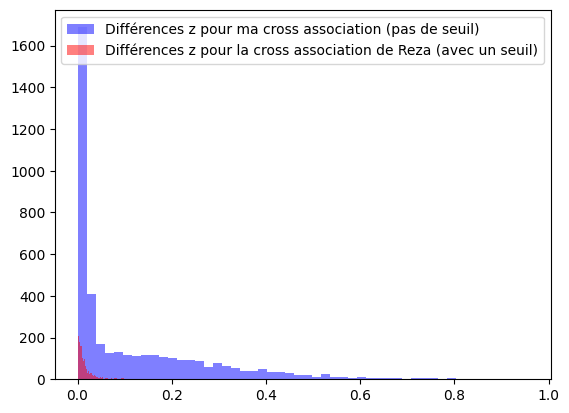

In [ ]:
diff_z_list_flatten = [item for sublist in diff_z_list for item in sublist] # On 'flatten' id_assos_list
plt.hist(diff_z_list_flatten,bins=50,label='Différences z pour ma cross association (pas de seuil)',color='blue',alpha=0.5)
plt.hist(np.abs(clx_catass_df_crossed['delz']),bins=50,label='Différences z pour la cross association de Reza (avec un seuil)',color='red',alpha=0.5)
plt.legend()

# Pourquoi il n'y a qu'un seul delz pour un objet avec plusieurs associations optiques dans clx_catass_df → seule diff_z la plus faible est prise en compte dans catass (mais il y a don d'autres diff_z 'valides'<0.15
# qui sont ignorés)


On remarque avec l'histogramme précédent que certaines de mes associations différent en z de plus de 0.15 (critère chosi par Reza dans clcxmatch.cc → ass_dz0): ce ne sont donc pas des associations valides → en fait c'est parce que pour l'instant je n'ai fait qu'un cross-match 2D


## Projection "eliptique"

In [ ]:
# Coordonnées galactiques objets X associés
raj2000_x_crossed_list = table_X_crossed['RAJ2000'].tolist()
dej2000_x_crossed_list = table_X_crossed['DEJ2000'].tolist()
j2000_coords_x_crossed = SkyCoord(raj2000_x_crossed_list, dej2000_x_crossed_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x_crossed = j2000_coords_x_crossed.galactic # conversion J2000 -> galactique

# Coordonnées galactiques objets optiques associées
raj2000_opt_crossed_list = table_optique_associated['RAJ2000'].tolist()
dej2000_opt_crossed_list = table_optique_associated['DEJ2000'].tolist()
j2000_coords_opt_crossed = SkyCoord(raj2000_opt_crossed_list, dej2000_opt_crossed_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt_crossed = j2000_coords_opt_crossed.galactic # conversion J2000 -> galactique

# Coordonnées galactiques objets X 
raj2000_x_list = table_X['RAJ2000'].tolist()
dej2000_x_list = table_X['DEJ2000'].tolist()
j2000_coords_x = SkyCoord(raj2000_x_list, dej2000_x_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x = j2000_coords_x.galactic # conversion J2000 -> galactique

# Coordonnées galactiques objets optiques 
raj2000_opt_list = table_optique['RAJ2000'].tolist()
dej2000_opt_list = table_optique['DEJ2000'].tolist()
j2000_coords_opt = SkyCoord(raj2000_opt_list, dej2000_opt_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt = j2000_coords_opt.galactic # conversion J2000 -> galactique

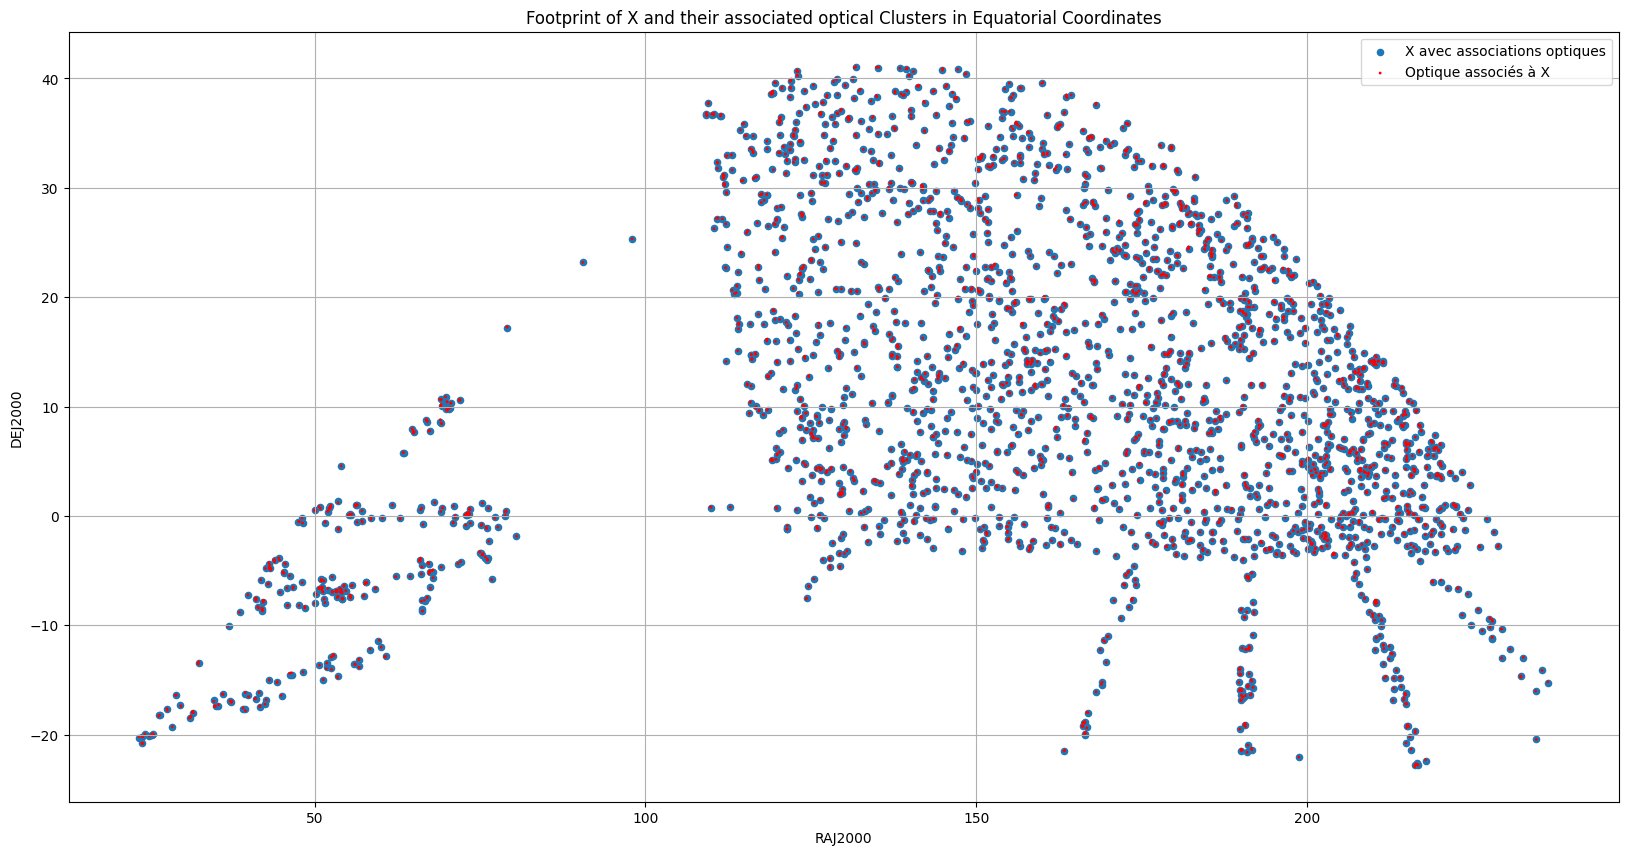

In [ ]:
#→ Adapt it for SkyCoord 'galactic_coords_x_crossed' and 'galactic_coords_opt_crossed'

'''# On récupère les coordonnées galactiques des objets X
X_glon = galactic_coords_x_crossed.l.value # Longitude galactique
X_glat = galactic_coords_x_crossed.b.value # Latitude galactique

# On récupère les coordonnées galactiques des objets optiques associés
opt_glon = galactic_coords_opt_crossed.l.value # Longitude galactique
opt_glat = galactic_coords_opt_crossed.b.value # Latitude galactique

# On convertit les coordonnées galactiques en radians
X_glon_radians = np.radians(X_glon) # Longitude galactique en radians
X_glat_radians = np.radians(X_glat) # Latitude galactique en radians
opt_glon_radians = np.radians(opt_glon) # Longitude galactique en radians
opt_glat_radians = np.radians(opt_glat) # Latitude galactique en radians'''


plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)

ax_projection_X.scatter(raj2000_x_crossed_list, dej2000_x_crossed_list, s=20,label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list, dej2000_opt_crossed_list, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates")
plt.legend()


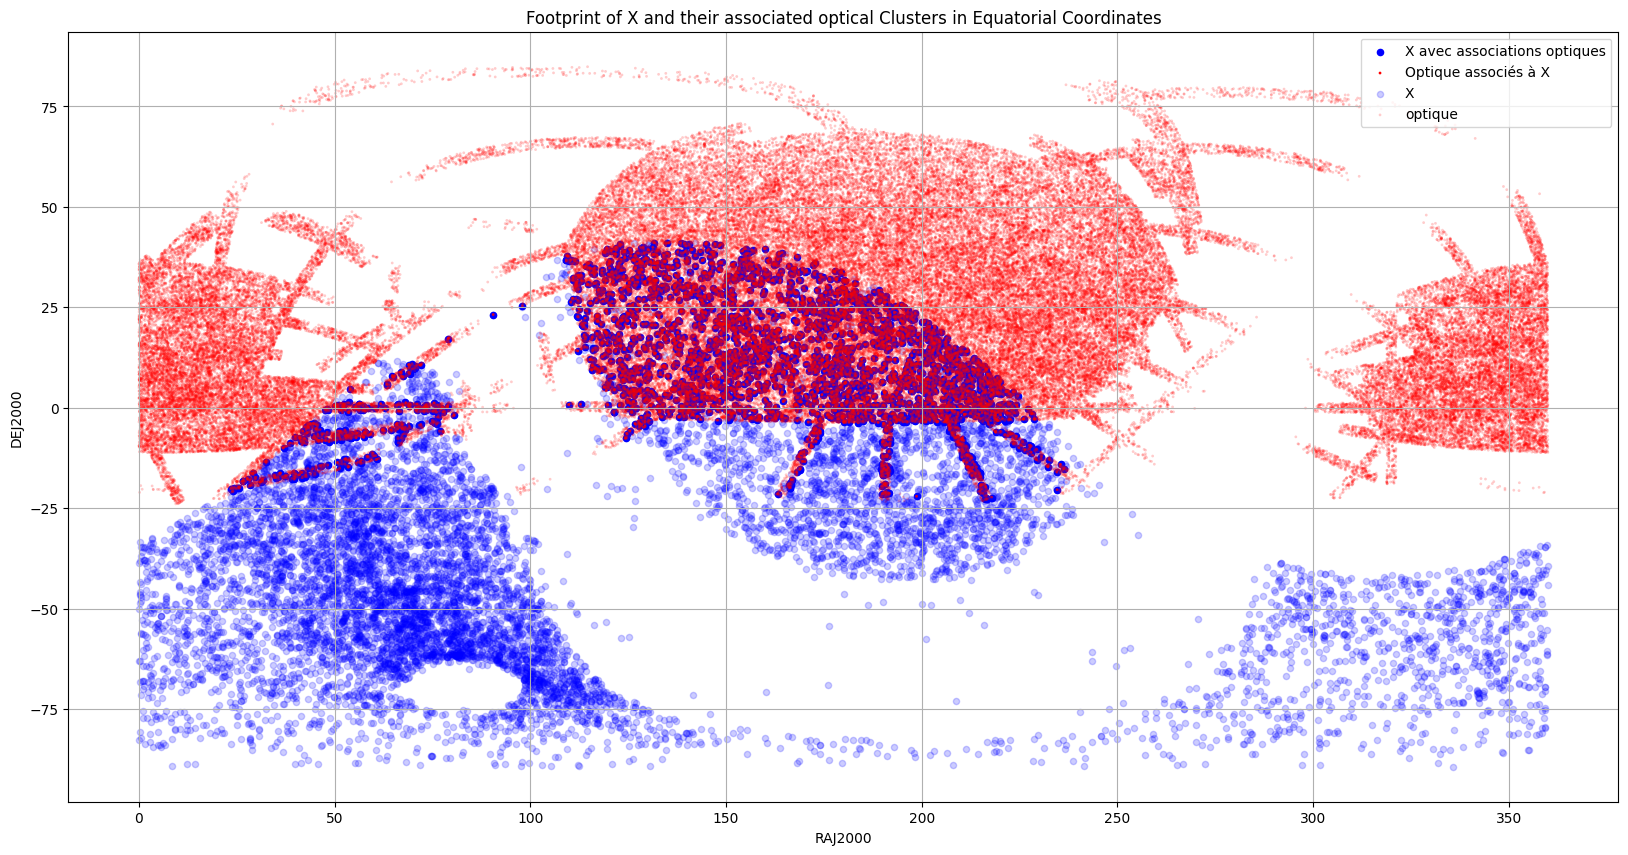

In [ ]:
#On projette la footprint des associations ainsi que l'ensemble des objets X et optique


plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)
ax_projection_X_all = plt.subplot(111)
ax_projection_opt_all = plt.subplot(111)


ax_projection_X.scatter(raj2000_x_crossed_list, dej2000_x_crossed_list, s=20,facecolors='blue',label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list, dej2000_opt_crossed_list, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

ax_projection_X_all.scatter(raj2000_x_list, dej2000_x_list, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_all.grid(True)
ax_projection_X_all.set_xlabel("RAJ2000")
ax_projection_X_all.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_list, dej2000_opt_list,s=1,edgecolors='red',facecolors='none',alpha=0.2,label='optique') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates")
plt.legend()



# Sélection zone cross-matchs et étude spécifique

Au vu de l'affichage précédent, on observe que les footprints de eROSITA et SDSS se superposent majoritairement sur une certaine zone (110<RA<230 et -5<DE<45) dont on va donc privilégier l'étude par la suite.

In [ ]:
#On sélectionne la zone d'intérêt
table_X_crossed_selected = table_X_crossed[(table_X_crossed['RAJ2000'] > 110)
                                           & (table_X_crossed['RAJ2000'] < 230)
                                           & (table_X_crossed['DEJ2000'] > -5)
                                           & (table_X_crossed['DEJ2000'] < 45)
                                           ]

table_optique_associated_selected = table_optique_associated[(table_optique_associated['RAJ2000'] > 110)
                                           & (table_optique_associated['RAJ2000'] < 230)
                                           & (table_optique_associated['DEJ2000'] > -5)
                                           & (table_optique_associated['DEJ2000'] < 45)
                                           ]

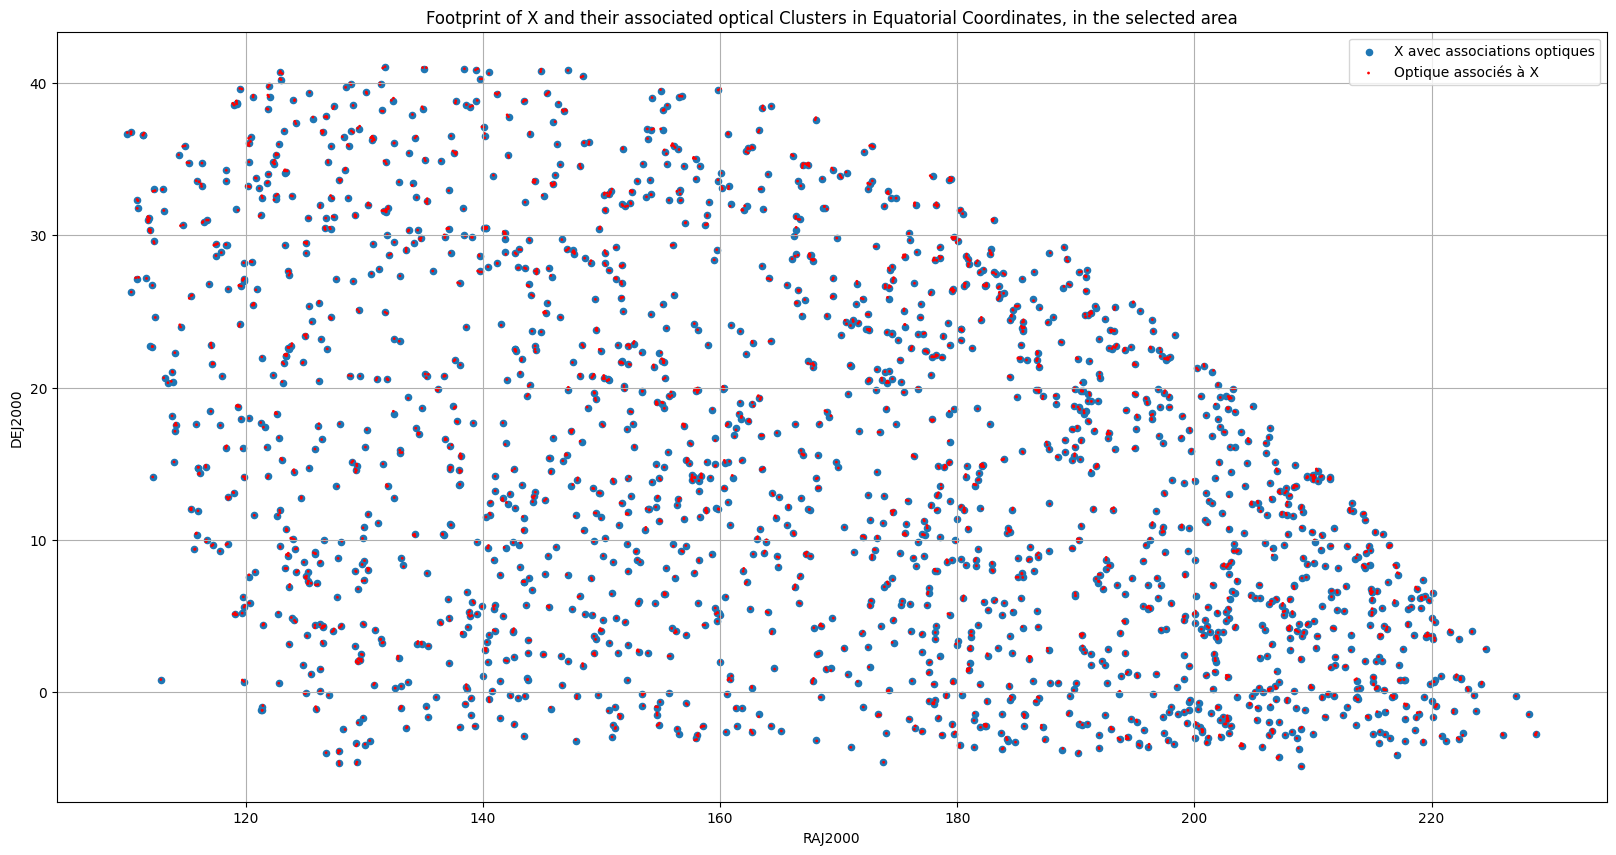

In [ ]:
#On projette les footprit de la zone sélectionnée

raj2000_x_crossed_list_selected = table_X_crossed_selected['RAJ2000'].tolist()
dej2000_x_crossed_list_seleceted = table_X_crossed_selected['DEJ2000'].tolist()

raj2000_opt_crossed_list_selected = table_optique_associated_selected['RAJ2000'].tolist()
dej2000_opt_crossed_list_seleceted = table_optique_associated_selected['DEJ2000'].tolist()

plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)

ax_projection_X.scatter(raj2000_x_crossed_list_selected, dej2000_x_crossed_list_seleceted, s=20,label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list_selected, dej2000_opt_crossed_list_seleceted, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates, in the selected area")
plt.legend()


In [ ]:
table_X_crossed_selected

,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,pcont,...,KT,Mgas500,YX500,M500,Fgas500,R500,nb_assos,id_assos,diff_z,dist_ang
6610,110.015084,36.628404,1eRASS J072003.6+363742 ...,110.015084,36.628404,73.599998,0.1300,0.0077,photo_z,0.942,...,NaN,6.930000,0.00,5.160000,0.016,543,1,[26724],[0.17770000476837156],[0.12144747740385785]
6619,110.323533,36.759256,1eRASS J072117.6+364533 ...,110.323533,36.759256,73.199997,0.1489,0.0054,photo_z,0.000,...,NaN,327.660004,0.00,30.930000,0.107,980,3,"[26755, 26757, 26764]","[0.09579999775886536, 0.0068999977588653505, 0...","[0.025648758995499208, 0.09420202470398938, 0...."
6620,110.341777,26.297616,1eRASS J072122.0+261751 ...,110.341777,26.297616,69.699997,0.1330,0.0049,photo_z,0.002,...,NaN,118.839996,0.00,14.890000,0.076,772,1,[26765],[0.05179999868869781],[0.022601190317863694]
6631,110.810886,32.343387,1eRASS J072314.6+322036 ...,110.810886,32.343387,71.900002,0.6067,0.0081,photo_z,0.104,...,NaN,284.679993,0.00,26.030001,0.099,778,2,"[26837, 26846]","[0.03309999685287479, 0.23500000314712527]","[0.033413436776991434, 0.11680063623426852]"
6634,110.859272,27.126866,1eRASS J072326.2+270736 ...,110.859272,27.126866,75.500000,0.5933,0.0119,photo_z,0.763,...,3.48,73.699997,366.19,39.230000,0.027,896,2,"[26811, 26857]","[0.2433999849319458, 0.2610999849319458]","[0.16956298793623859, 0.1454461718984394]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10983,224.562304,2.849343,1eRASS J145814.9+025057 ...,224.562304,2.849343,159.899994,0.3492,0.0004,cg_spec_z,0.004,...,NaN,NaN,NaN,NaN,NaN,-2147483648,2,"[93529, 93595]","[0.15829998970031733, 0.0195999897003174]","[0.13353540666179475, 0.0010106380805561888]"
11009,226.031812,-2.804575,1eRASS J150407.6-024816 ...,226.031812,-2.804575,155.199997,0.2093,0.0048,photo_z,0.000,...,7.83,1282.209961,9885.18,161.770004,0.079,1665,3,"[94439, 94455, 94486]","[0.2696000035047531, 0.1230000035047531, 0.007...","[0.09519647009941774, 0.04800119241542491, 0.0..."
11033,227.114796,-0.245714,1eRASS J150827.5-001444 ...,227.114796,-0.245714,159.500000,0.0901,0.0004,spec_z_boot,0.003,...,1.43,50.689999,76.43,7.960000,0.059,636,1,[95111],[0.012300002181530004],[0.021869584989795954]
11056,228.212956,-1.471880,1eRASS J151251.1-012818 ...,228.212956,-1.471880,162.100006,0.1221,0.0006,spec_z_boot,0.000,...,7.16,223.750000,1572.84,34.669998,0.064,1027,2,"[95739, 95762]","[0.09139999693632125, 0.015799996936321253]","[0.04278280019233761, 0.006543127830256659]"


In [ ]:

table_X_crossed_selected = table_X_crossed_selected[table_X_crossed_selected['diff_z'] < delta_z]
table_optique_associated_selected = table_optique_associated_selected[table_optique_associated_selected['diff_z'] < delta_z]

TypeError: '<' not supported between instances of 'list' and 'float'

In [ ]:
table_X_crossed_selected['diff_z']

6660      [0.03819998435974126]
6676      [0.10059998970031736]
6683      [0.01809999380111693]
6684     [0.009899994421005254]
6688     [0.007899991035461407]
                  ...          
10971    [0.009899990510940537]
10983      [0.0195999897003174]
11009    [0.007700003504753111]
11056    [0.015799996936321253]
11072    [0.004000003659725193]
Name: diff_z, Length: 779, dtype: object